## import the libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import shutil


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.17.0


In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

## Preprocessing

- check the dataset and divide it in train, test and val
- apply pre processing steps and check if there is any correupt file

In [ ]:
def create_and_copy_dataset(base_dir, main_categories, exclude_subcategories={}):
    working_dir = '/content/drive/MyDrive/fyllo/'

    for main_cat in main_categories:
        # Create main category directories in a writeable location
        os.makedirs(os.path.join(working_dir, 'train', main_cat), exist_ok=True)
        os.makedirs(os.path.join(working_dir, 'val', main_cat), exist_ok=True)
        os.makedirs(os.path.join(working_dir, 'test', main_cat), exist_ok=True)

        main_cat_dir = os.path.join(base_dir, main_cat)
        if not os.path.exists(main_cat_dir):
            print(f"Directory not found: {main_cat_dir}")
            continue

        all_files = []
        for sub_cat in os.listdir(main_cat_dir):
            sub_cat_dir = os.path.join(main_cat_dir, sub_cat)

            # Skip if the subcategory is in the exclude list
            if sub_cat in exclude_subcategories.get(main_cat, []):
                continue

            if os.path.isdir(sub_cat_dir):
                # Handle sub-directories
                files = [os.path.join(sub_cat_dir, f) for f in os.listdir(sub_cat_dir) if os.path.isfile(os.path.join(sub_cat_dir, f))]
                all_files.extend(files)
            else:
                # Handle direct files in main category folder
                if os.path.isfile(sub_cat_dir):
                    all_files.append(sub_cat_dir)

        # Shuffle and split files
        np.random.shuffle(all_files)
        total_files = len(all_files)
        train_split = int(0.7 * total_files)
        val_split = int(0.85 * total_files)

        for i, file_path in enumerate(all_files):
            if i < train_split:
                shutil.copy(file_path, os.path.join(working_dir, 'train', main_cat))
            elif i < val_split:
                shutil.copy(file_path, os.path.join(working_dir, 'val', main_cat))
            else:
                shutil.copy(file_path, os.path.join(working_dir, 'test', main_cat))

# Example usage
main_categories = ['Damaged_Infrastructure', 'Fire_Disaster', 'Human_Damage', 'Land_Disaster', 'Non_Damage', 'Water_Disaster']
exclude_subcategories = {'Land_Disaster': ['Land_Slide']}
base_dir = '/content/drive/MyDrive/fyllo/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/'
create_and_copy_dataset(base_dir, main_categories, exclude_subcategories)


In [ ]:
# Define directory paths
train_dir = '/content/drive/MyDrive/fyllo/train'
val_dir = '/content/drive/MyDrive/fyllo/val'
test_dir = '/content/drive/MyDrive/fyllo/test'

# Other parameters
img_width, img_height = 256, 256  # Adjust as needed
batch_size = 32  # Adjust as needed

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,      # Random rotations in the range of 0 to 40 degrees
#     width_shift_range=0.2,  # Random horizontal shifts
#     height_shift_range=0.2, # Random vertical shifts
#     shear_range=0.2,        # Shear transformation
#     zoom_range=0.2,         # Random zoom
#     horizontal_flip=True,   # Random horizontal flips
#     fill_mode='nearest'     # Strategy to fill newly created pixels
# )



In [ ]:
import glob
from PIL import Image

def validate_and_fix_images(folder_path):
    for img_path in glob.glob(os.path.join(folder_path, '**/*'), recursive=True):
        if os.path.isfile(img_path):
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify the integrity of the file
                    img.seek(0)   # Reset file pointer
                    img = Image.open(img_path)
                    img.load()    # Load the image data
            except (OSError, Exception) as e:
                print('Problematic file:', img_path, 'Error:', e)
                os.remove(img_path)  # Optionally remove the corrupted file

validate_and_fix_images('/content/drive/MyDrive/fyllo/')

In [ ]:
# Flow data from directories
# set the categorical labels to be inferred from the subdirectory names
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')



val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


Found 9187 images belonging to 6 classes.
Found 1964 images belonging to 6 classes.
Found 1969 images belonging to 6 classes.


## Transfer learning

- using resnet50 with imagenet model weights
- use early stopping to get best weights

In [ ]:
# import the pretrained imagenet models

# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import ResNet50


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))


# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False


# add custom layers - transfer learning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)


# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
#checking the subdirectories image distribution

def count_images(base_dir, subsets):
    distribution = {}
    for subset in subsets:
        distribution[subset] = {}
        subset_dir = os.path.join(base_dir, subset)
        if not os.path.exists(subset_dir):
            print(f"Directory not found: {subset_dir}")
            continue

        for class_name in os.listdir(subset_dir):
            class_dir = os.path.join(subset_dir, class_name)
            if not os.path.isdir(class_dir):
                continue

            count = len([name for name in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, name))])
            distribution[subset][class_name] = count
    return distribution

base_dir = '/content/drive/MyDrive/fyllo/'  # Replace with your base directory
subsets = ['train', 'val', 'test']
distribution = count_images(base_dir, subsets)

for subset, classes in distribution.items():
    print(f"Subset: {subset}")
    for class_name, count in classes.items():
        print(f"  {class_name}: {count}")
    print()


Subset: train
  Land_Disaster: 140
  Fire_Disaster: 653
  Non_Damage: 6485
  Damaged_Infrastructure: 1017
  Water_Disaster: 724
  Human_Damage: 168

Subset: val
  Damaged_Infrastructure: 218
  Fire_Disaster: 140
  Human_Damage: 35
  Land_Disaster: 30
  Non_Damage: 1386
  Water_Disaster: 155

Subset: test
  Damaged_Infrastructure: 219
  Non_Damage: 1386
  Land_Disaster: 31
  Water_Disaster: 156
  Fire_Disaster: 140
  Human_Damage: 37



In [ ]:
def verify_images(folder_path):
    corrupted_files = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(root, file)
                    with Image.open(img_path) as img:
                        img.verify()  # Verify the integrity of the file
                except (IOError, SyntaxError) as e:
                    print(f'Corrupted file: {img_path}')
                    corrupted_files.append(img_path)

    return corrupted_files

folder_path = '/content/drive/MyDrive/fyllo/'  # Replace with the path to your dataset
corrupted_files = verify_images(folder_path)

print(f'Found {len(corrupted_files)} corrupted files.')


Found 0 corrupted files.


In [ ]:
from PIL import Image
import os
import glob

def verify_images(folder_path):
    # Using glob.glob to search for all PNG files in the directory and its subdirectories
    for img_path in glob.glob(os.path.join(folder_path, '**/*.png'), recursive=True):
        try:
#             print(f'Checking: {img_path}')
            with Image.open(img_path) as img:
                img.verify()  # Verify the integrity of the image
        except (IOError, SyntaxError) as e:
            print('Bad file:', img_path)  # Print out the paths of corrupted files
            os.remove(img_path)  # Optionally remove the corrupted file

# Replace 'your_image_folder_path' with the path to your dataset folder
# verify_images('/kaggle/working/')


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the model checkpoint callback to save the best model based on validation loss
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/fyllo/image_disaster_model.keras',  # Path where to save the best model
    save_best_only=True,                          # Save only the best model
    monitor='val_loss',                           # Monitor the validation loss
    mode='min',                                   # Save the model with minimum validation loss
    verbose=2                                     # Verbosity mode
)

# Define early stopping to stop training when validation loss stops improving
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  
    patience=5,          # Number of epochs to wait after the last improvement
    mode='min',          # Minimize the validation loss
    verbose=2           
)

# Fit the model with both callbacks (model checkpoint and early stopping)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=50,                                      # Number of epochs
    callbacks=[model_checkpoint_callback, early_stopping_callback]  # Add both callbacks
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7059 - loss: 1.0092
Epoch 1: val_loss improved from inf to 0.68755, saving model to /content/drive/MyDrive/fyllo/disaster_model.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 1612s 5s/step - accuracy: 0.7060 - loss: 1.0087 - val_accuracy: 0.7531 - val_loss: 0.6875
Epoch 2/50
  1/287 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - accuracy: 0.8125 - loss: 0.6506

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.68755
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8125 - loss: 0.6506 - val_accuracy: 0.6667 - val_loss: 0.8573
Epoch 3/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7497 - loss: 0.7047
Epoch 3: val_loss improved from 0.68755 to 0.64300, saving model to /content/drive/MyDrive/fyllo/disaster_model.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 110s 267ms/step - accuracy: 0.7497 - loss: 0.7047 - val_accuracy: 0.8197 - val_loss: 0.6430
Epoch 4/50
  1/287 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step - accuracy: 0.7500 - loss: 0.7868
Epoch 4: val_loss did not improve from 0.64300
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step - accuracy: 0.7500 - loss: 0.7868 - val_accuracy: 0.7500 - val_loss: 0.6830
Epoch 5/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7625 - loss: 0.6715
Epoch 5: val_loss improved from 0.64300 to 0.58957, saving model to /content/drive/MyDrive/fyllo/disaster_model.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 84s 274ms/step - a

In [ ]:
def plot_train_val_loss_acc(history):
    # Summarize history for accuracy
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Train vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Show plots
    plt.tight_layout()
    plt.show()

# After model training
plot_train_val_loss_acc(history)


62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step


<Figure size 1200x800 with 0 Axes>

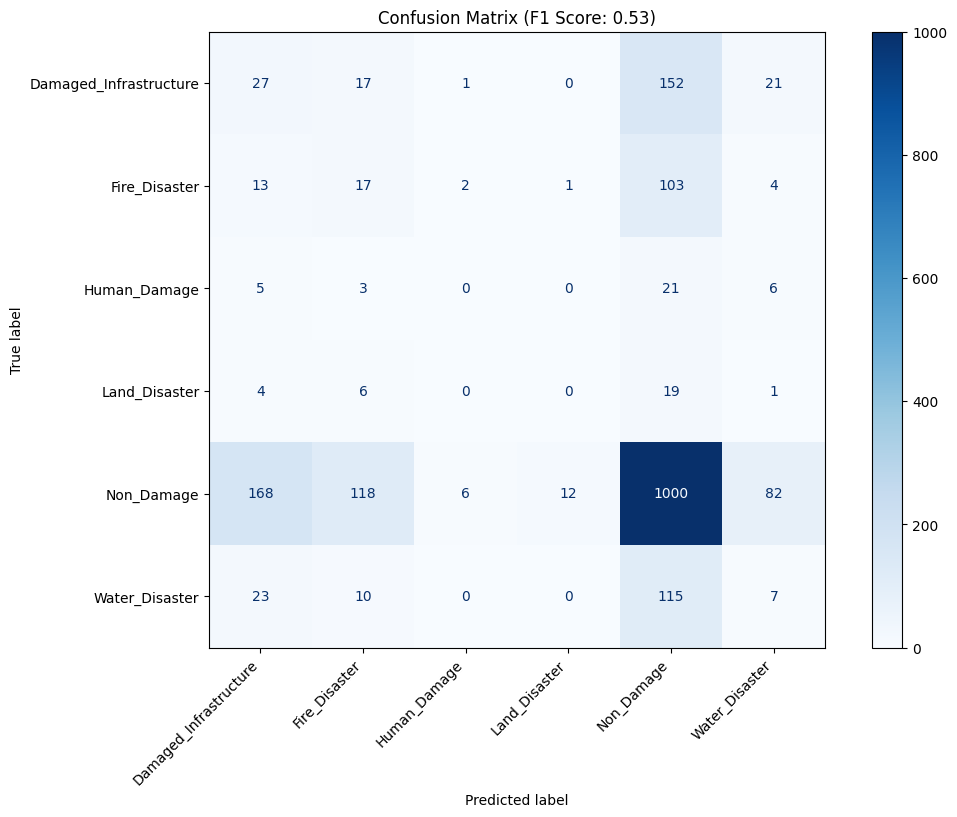

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

# Function to plot confusion matrix and F1 score
def plot_confusion_matrix(model, val_generator):

    # Get predictions from the model
    plt.figure(figsize=(12, 8))
    y_pred = model.predict(val_generator)

    # Convert predictions from probabilities to class labels (assuming softmax output)
    y_pred_classes = np.argmax(y_pred, axis=1)
    # Get true class labels
    y_true = val_generator.classes  # Assuming the generator has the true labels


    cm = confusion_matrix(y_true, y_pred_classes)
    f1 = f1_score(y_true, y_pred_classes, average='weighted')  # Use 'weighted' for multi-class problems
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())

    fig, ax = plt.subplots(figsize=(12, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax)


    plt.xticks(rotation=45, ha='right')
    plt.title(f'Confusion Matrix (F1 Score: {f1:.2f})')
    plt.show()

# After model evaluation, call this function
plot_confusion_matrix(model, val_generator)


## Load and test the model

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


# Load the saved model
model = load_model('/content/drive/MyDrive/fyllo/disaster_model.keras')

# Preprocessing function
datagen = ImageDataGenerator(rescale=1./255)

def preprocess_image(img_path, target_size=(256, 256)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = datagen.flow(img_array, batch_size=1)[0]  # Apply preprocessing
    return img_array




# Load and preprocess a new image
img_path = '/content/water.jpg'
processed_image = preprocess_image(img_path)

# Make a prediction
pred = model.predict(processed_image)
predicted_class = np.argmax(pred, axis=1)

# Class label mapping
class_labels = {0: 'Land_Disaster', 1: 'Fire_Disaster', 2: 'Non_Damage', 3: 'Damaged_Infrastructure', 4: 'Water_Disaster', 5: 'Human_Damage'}
predicted_label = class_labels[predicted_class[0]]


print(f"Predicted class: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class: Class 4
